# Import Packages

In [1]:
# Import packages
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT)
0,M,YOUNG,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,0.301196
1,F,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,0.301196
2,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,0.419251
3,M,YOUNG,Y,L,N,N,Y,L,4,Alive,Alive and recovered,1,0.274168
4,M,OLD,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,0.301196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,M,YOUNG,N,L,N,N,N,L,2,Alive,Alive and recovered,1,0.274168
2496,F,YOUNG,N,L,N,N,Y,L,2,Alive,Alive and recovered,1,0.274168
2497,F,OLD,Y,N,N,N,Y,N,3,Alive,Alive and recovered,1,0.274168
2498,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,0.419251


In [3]:
# Generate a list of 2500 tuples of gender and age values
# AGE: OLD = 1, YOUNG = 0
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)

gender_list = logs_df['SEX_new'].to_numpy()
age_list = logs_df['AGE_new'].to_numpy()

gender_age_list = list(zip(gender_list, age_list))
gender_age_list = np.array(gender_age_list)
gender_age_list


array([[1, 0],
       [0, 1],
       [1, 1],
       ...,
       [0, 1],
       [1, 1],
       [0, 1]])

# Arms

In [4]:
class LinUCB:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.alpha = alpha
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]

    def update(self, arm, x_t, reward):
        self.A[arm] += np.outer(x_t, x_t)
        self.b[arm] += reward * x_t

    def recommend(self, x_t):
        scores = np.zeros(self.n_arms)
        thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv @ self.b[arm]
            p_arm = theta.T @ x_t + self.alpha * np.sqrt(x_t.T @ A_inv @ x_t)
            scores[arm] = p_arm
            thetas[arm] = theta
        return np.argmax(scores), thetas, scores

# Simulation and Tuning

In [5]:
def simulate_one_time_reward(arm, x_t, theta, scale_noise = 0.01):
    signal = theta @ x_t
    noise  = np.random.normal(scale = scale_noise) 
    return (signal + noise)

In [6]:
# Implement Simulation Test
def test_algorithm(algo, n_arms, n_features, n_sims, n_steps, alpha, gender_age_list):
    chosen_arms = [0 for i in range(n_sims * n_steps)]
    rewards = [0 for i in range(n_sims * n_steps)]
    cumulative_rewards = [0 for i in range(n_sims * n_steps)]
    sim_rounds = [0 for i in range(n_sims * n_steps)]
    time_steps = [0 for i in range(n_sims * n_steps)]
    
    for sim in range(n_sims):
        sim = sim + 1
        
        for t in range(n_steps):
            x_t = gender_age_list[t]
            t = t + 1
            index = (sim-1) * n_steps + t - 1
            sim_rounds[index] = sim
            time_steps[index] = t
            
            chosen_arm, thetas, scores = algo.recommend(x_t)
            chosen_arms[index] = chosen_arm
            
            theta = thetas[chosen_arm]
            
            reward = simulate_one_time_reward(chosen_arm, x_t, theta, scale_noise = 0.01)
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward 
            
            algo.update(chosen_arm, x_t, reward)

    return (sim_rounds, time_steps, chosen_arms, rewards, cumulative_rewards)

In [7]:
n_steps = gender_age_list.shape[0]
n_sims = 20
alpha_values = [0.1, 0.3, 0.5, 0.7, 1.0]
num_features = 2
num_arms = 4
all_results_linUCB = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])

In [8]:
for alpha in alpha_values:
    linUCB_algo = LinUCB(num_arms, num_features, alpha)
    results_linUCB = pd.DataFrame(test_algorithm(linUCB_algo, num_arms, num_features, 
                                                  n_sims, n_steps, alpha, gender_age_list)).transpose()
    results_linUCB.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
    results_linUCB["alpha"] = alpha
    all_results_linUCB = pd.concat([all_results_linUCB, results_linUCB])

In [9]:
all_results_linUCB["n_sim"] = all_results_linUCB["n_sim"].astype(int)
all_results_linUCB["n_step"] = all_results_linUCB["n_step"].astype(int)
all_results_linUCB["chosen_treatment"] = all_results_linUCB["chosen_treatment"].astype(int)
all_results_linUCB = all_results_linUCB.reset_index(drop = True)

In [10]:
all_results_linUCB

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,alpha
0,1,1,0,-0.009065,-0.009065,0.1
1,1,2,0,0.000901,-0.008164,0.1
2,1,3,1,0.007925,-0.000239,0.1
3,1,4,2,-0.005125,-0.005364,0.1
4,1,5,3,0.009152,0.003789,0.1
...,...,...,...,...,...,...
249995,20,2496,2,-0.001504,26.406138,1.0
249996,20,2497,0,0.015127,26.421266,1.0
249997,20,2498,3,-0.002977,26.418288,1.0
249998,20,2499,0,0.024502,26.442791,1.0


In [11]:
# If chosen_treatment = to the treatment with highest click_probability, return 1 else 0
success_probabilities_linUCB = [0.6, 0.4, 0.8, 0.9]

all_results_linUCB['if_best_treatment'] = np.where(all_results_linUCB['chosen_treatment'] == success_probabilities_linUCB.index(max(success_probabilities_linUCB)), 1, 0)

# Group by epsilon and n_step,
results_plot_linUCB = all_results_linUCB.groupby(['alpha', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [12]:
results_plot_linUCB

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.1,1,0.00,0.008339,0.008339
1,0.1,2,0.85,0.007444,0.015784
2,0.1,3,0.95,0.008767,0.024551
3,0.1,4,0.00,0.004369,0.028920
4,0.1,5,1.00,0.008394,0.037314
...,...,...,...,...,...
12495,1.0,2496,0.10,0.000328,23.442540
12496,1.0,2497,0.00,0.000454,23.442995
12497,1.0,2498,0.05,0.013411,23.456406
12498,1.0,2499,0.05,0.013119,23.469524


## Rewards

Text(0.5, 1.0, 'The probability of choosing the best treatment')

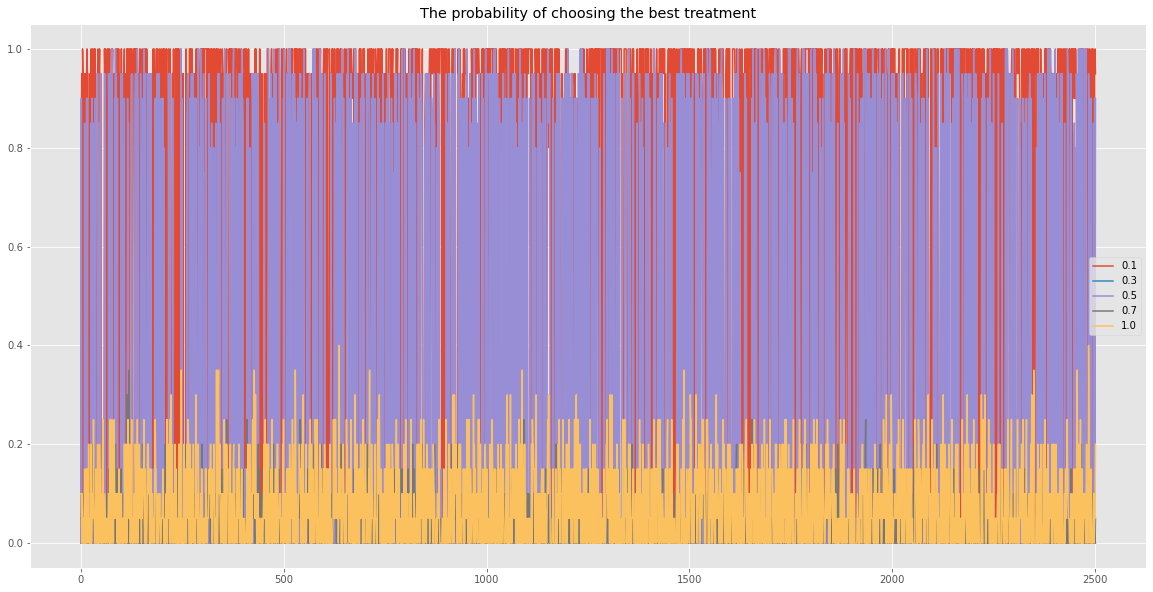

In [13]:
plt.style.use('ggplot')

# Plot the probability of choosing the best movie
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['if_best_treatment'], label = str(alpha))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

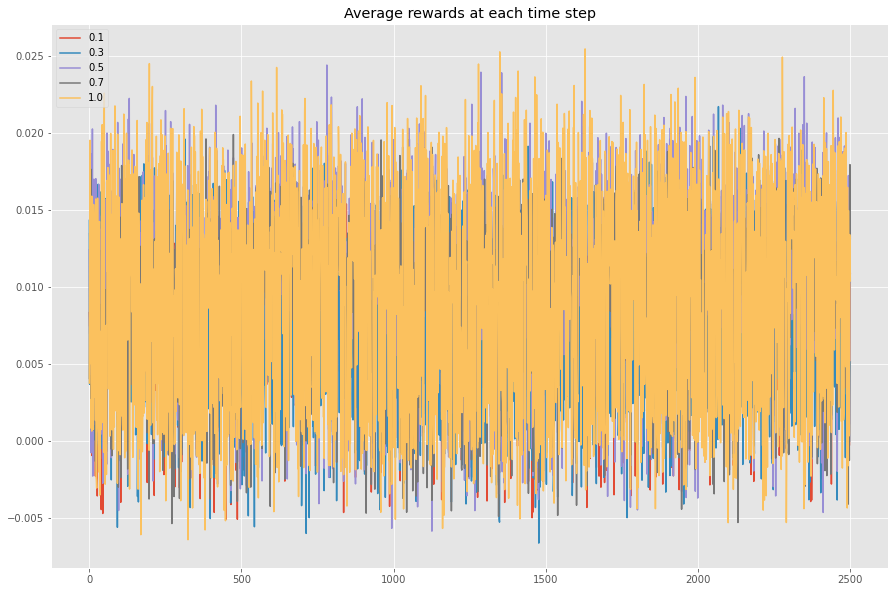

In [14]:
# plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['rewards'], label = str(alpha))

plt.legend()
plt.title("Average rewards at each time step")

In [15]:
# Determine the cumulative reward at 1000 time step
results_plot_linUCB[results_plot_linUCB["n_step"] == 2500]

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
2499,0.1,2500,0.95,0.010896,18.858562
4999,0.3,2500,0.05,0.005136,18.798576
7499,0.5,2500,0.90,0.010299,28.076670
9999,0.7,2500,0.00,0.013145,24.438057
12499,1.0,2500,0.20,0.010410,23.479935


Text(0.5, 1.0, 'Cumulative rewards at each step')

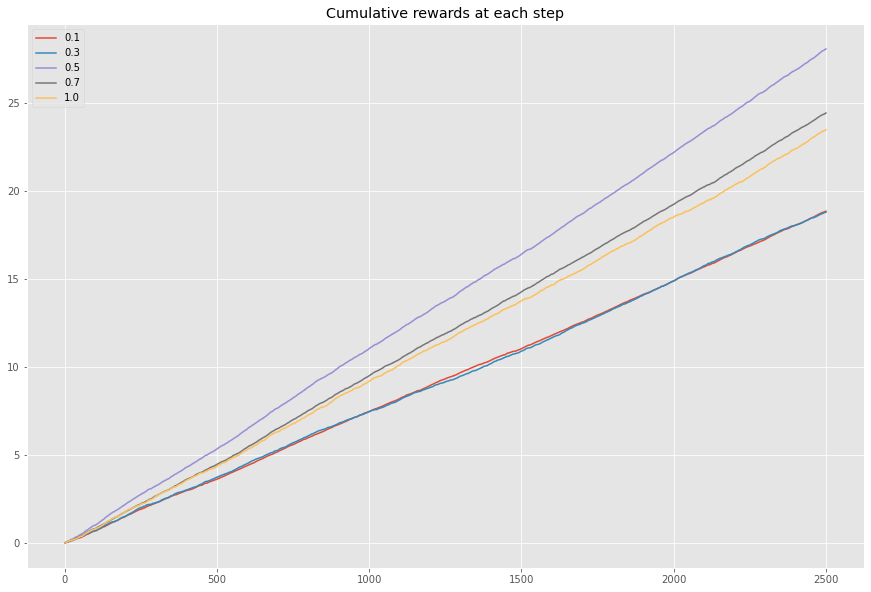

In [16]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
    
for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['cumulative_rewards'], label = str(alpha))

plt.legend()
plt.title("Cumulative rewards at each step")